# Random Forest classifier

In [19]:
import numpy as np
import matplotlib.pyplot as plt
import matplotlib
matplotlib.style.use('seaborn-v0_8-colorblind')
import pandas as pd

from sklearn.ensemble import RandomForestClassifier
from sklearn.model_selection import train_test_split
from sklearn import metrics
from sklearn.model_selection import StratifiedKFold
from sklearn.metrics import roc_curve, auc

from src.utils.ds_formatter import format_all
from src.dataset import *
plt.rcParams['figure.dpi'] = 40
OLD_F_METADATA = "./data/HT_Sensor_metadata.dat"
F_METADATA = "./data/HT_Sensor_metadata_new.dat"
OLD_F_DATASET = "./data/HT_Sensor_dataset.dat"
F_DATASET = "./data/HT_Sensor_dataset_new.dat"

FEATURES = [
  'R1', 'R1_mean', 'R1_median', 'R1_dev',
  'R2', 'R2_mean', 'R2_median', 'R2_dev',
  'R3', 'R3_mean', 'R3_median', 'R3_dev',
  'R4', 'R4_mean', 'R4_median', 'R4_dev',
  'R5', 'R5_mean', 'R5_median', 'R5_dev',
  'R6', 'R6_mean', 'R6_median', 'R6_dev',
  'R7', 'R7_mean', 'R7_median', 'R7_dev',
  'R8', 'R8_mean', 'R8_median', 'R8_dev',
  'Temp.', 'Temp._mean', 'Temp._median', 'Temp._dev',
  'Humidity', 'Hum_mean', 'Hum_median', 'Hum_dev'
]

In [2]:
df = get_dataset(build_dataset=False, time_window=5)
df.shape

(253699, 41)

In [3]:
X=df[FEATURES]
y=df['class']

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3)
print(f'{X_train.shape} {y_train.shape} {X_test.shape} {y_test.shape}')

(177589, 40) (177589,) (76110, 40) (76110,)


In [4]:
from sklearn.ensemble import RandomForestClassifier

clf=RandomForestClassifier(n_estimators=10, bootstrap=True, verbose=1)

In [5]:
clf.fit(X_train,y_train)

[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done  10 out of  10 | elapsed:    9.3s finished


RandomForestClassifier(n_estimators=10, verbose=1)

In [6]:
y_pred=clf.predict(X_test)

[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done  10 out of  10 | elapsed:    0.0s finished


In [7]:
print("Accuracy:",metrics.accuracy_score(y_test, y_pred))
print("F1-score:",metrics.f1_score(y_test, y_pred, average='weighted'))
print("Confusion matrix:\n",metrics.confusion_matrix(y_test, y_pred))

Accuracy: 0.9999868611220601
F1-score: 0.9999868611591055
Confusion matrix:
 [[20266     0     0]
 [    0 23629     0]
 [    0     1 32214]]


No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.


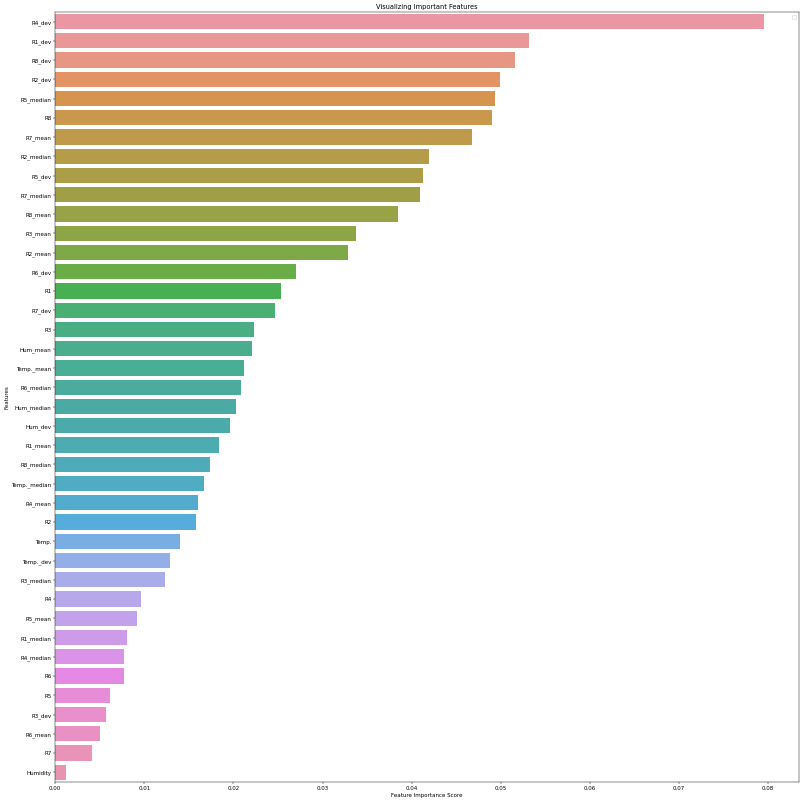

In [8]:
feature_imp = pd.Series(clf.feature_importances_,index=FEATURES).sort_values(ascending=False)
import seaborn as sns
fig, ax = plt.subplots(figsize=(24, 25))
# Creating a bar plot
sns.barplot(x=feature_imp, y=feature_imp.index, ax=ax)
# Add labels to your graph
plt.xlabel('Feature Importance Score')
plt.ylabel('Features')
plt.title("Visualizing Important Features")
plt.legend()
plt.show()

Ahora probamos a entrenar el modelo con las features mas relevantes

In [9]:
FEATURES_2 = [
  'R1', 'R1_mean', 'R1_median', 'R1_dev',
  'R2', 'R2_mean', 'R2_median', 'R2_dev',
  'R3', 'R3_mean', 'R3_median', 'R3_dev',
  'R4', 'R4_mean', 'R4_median', 'R4_dev',
  'R5', 'R5_mean', 'R5_median', 'R5_dev',
  'R6', 'R6_mean', 'R6_median', 'R6_dev',
  'R7', 'R7_mean', 'R7_median', 'R7_dev',
  'R8', 'R8_mean', 'R8_median', 'R8_dev'
]
X=df[FEATURES_2]
y=df['class']

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3)
print(f'{X_train.shape} {y_train.shape} {X_test.shape} {y_test.shape}')

(177589, 32) (177589,) (76110, 32) (76110,)


In [10]:
clf=RandomForestClassifier(n_estimators=10, bootstrap=True, verbose=1)
clf.fit(X_train,y_train)
y_pred=clf.predict(X_test)

[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done  10 out of  10 | elapsed:    8.4s finished
[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done  10 out of  10 | elapsed:    0.0s finished


In [11]:
print("Accuracy:",metrics.accuracy_score(y_test, y_pred))
print("F1-score:",metrics.f1_score(y_test, y_pred, average='weighted'))
print("Confusion matrix:\n",metrics.confusion_matrix(y_test, y_pred))

Accuracy: 0.9999737222441204
F1-score: 0.9999737221343636
Confusion matrix:
 [[20460     0     0]
 [    0 23574     0]
 [    1     1 32074]]


Como podemos ver, las métricas salen muy parecidas.

Ahora vamos a probar con K-Fold Cross-Validation:

In [14]:
def plot_roc_curve(fprs, tprs):
    """Plot the Receiver Operating Characteristic from a list
    of true positive rates and false positive rates."""
    
    # Initialize useful lists + the plot axes.
    tprs_interp = []
    aucs = []
    mean_fpr = np.linspace(0, 1, 100)
    f, ax = plt.subplots(figsize=(14,10))
    
    # Plot ROC for each K-Fold + compute AUC scores.
    for i, (fpr, tpr) in enumerate(zip(fprs, tprs)):
        tprs_interp.append(np.interp(mean_fpr, fpr, tpr))
        tprs_interp[-1][0] = 0.0
        roc_auc = auc(fpr, tpr)
        aucs.append(roc_auc)
        ax.plot(fpr, tpr, lw=1, alpha=0.3,
                 label='ROC fold %d (AUC = %0.2f)' % (i, roc_auc))
        
    # Plot the luck line.
    plt.plot([0, 1], [0, 1], linestyle='--', lw=2, color='r',
             label='Luck', alpha=.8)
    
    # Plot the mean ROC.
    mean_tpr = np.mean(tprs_interp, axis=0)
    mean_tpr[-1] = 1.0
    mean_auc = auc(mean_fpr, mean_tpr)
    std_auc = np.std(aucs)
    ax.plot(mean_fpr, mean_tpr, color='b',
             label=r'Mean ROC (AUC = %0.2f $\pm$ %0.2f)' % (mean_auc, std_auc),
             lw=2, alpha=.8)
    
    # Plot the standard deviation around the mean ROC.
    std_tpr = np.std(tprs_interp, axis=0)
    tprs_upper = np.minimum(mean_tpr + std_tpr, 1)
    tprs_lower = np.maximum(mean_tpr - std_tpr, 0)
    ax.fill_between(mean_fpr, tprs_lower, tprs_upper, color='grey', alpha=.2,
                     label=r'$\pm$ 1 std. dev.')
    
    # Fine tune and show the plot.
    ax.set_xlim([-0.05, 1.05])
    ax.set_ylim([-0.05, 1.05])
    ax.set_xlabel('False Positive Rate')
    ax.set_ylabel('True Positive Rate')
    ax.set_title('Receiver operating characteristic')
    ax.legend(loc="lower right")
    plt.show()
    return (f, ax)

def compute_roc_auc(index):
    y_predict = clf.predict_proba(X.iloc[index])[:,1]
    fpr, tpr, thresholds = roc_curve(y.iloc[index], y_predict)
    auc_score = auc(fpr, tpr)
    return fpr, tpr, auc_score

In [24]:
KFOLDS = 5
cv = StratifiedKFold(n_splits=KFOLDS, shuffle=True)

results = pd.DataFrame(columns=['training_score', 'test_score'])
fprs, tprs, scores = [], [], []

X=df[FEATURES]
y=df['class']

for (train, test), i in zip(cv.split(X, y), range(KFOLDS)):
    print(f'FOLD nº{i}')
    X_train, X_test, y_train, y_test = X.iloc[train], X.iloc[test], y.iloc[train], y.iloc[test]
    
    clf.fit(X_train, y_train)
    y_pred = clf.predict(X_test)
    print("Accuracy:\t",metrics.accuracy_score(y_test, y_pred))
    print("Precision:\t",metrics.precision_score(y_test, y_pred, average='weighted'))
    print("Recall:\t\t",metrics.recall_score(y_test, y_pred, average='weighted'))
    print("F1-score:\t",metrics.f1_score(y_test, y_pred, average='weighted'))

FOLD nº0


[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done  10 out of  10 | elapsed:    9.8s finished
[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done  10 out of  10 | elapsed:    0.0s finished


Accuracy:	 0.9999408750492708
Precision:	 0.9999408815270068
Recall:		 0.9999408750492708
F1-score:	 0.9999408746053884
FOLD nº1


[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done  10 out of  10 | elapsed:   10.3s finished
[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done  10 out of  10 | elapsed:    0.0s finished


Accuracy:	 1.0
Precision:	 1.0
Recall:		 1.0
F1-score:	 1.0
FOLD nº2


[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done  10 out of  10 | elapsed:    9.9s finished
[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done  10 out of  10 | elapsed:    0.0s finished


Accuracy:	 0.9999802916830902
Precision:	 0.9999802929392771
Recall:		 0.9999802916830902
F1-score:	 0.99998029176789
FOLD nº3


[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done  10 out of  10 | elapsed:    9.9s finished
[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done  10 out of  10 | elapsed:    0.0s finished


Accuracy:	 0.9999802916830902
Precision:	 0.9999802931362918
Recall:		 0.9999802916830902
F1-score:	 0.9999802918171362
FOLD nº4


[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done  10 out of  10 | elapsed:   10.2s finished
[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done  10 out of  10 | elapsed:    0.0s finished


Accuracy:	 1.0
Precision:	 1.0
Recall:		 1.0
F1-score:	 1.0


Wow :O